## Fitting PPXF to one mock - example notebook

This notebook exemplifies how to read one mock from the mini mocha challenge, using the GQP_MC tools, and fit it with PPXF using two simple templates. 

Notes:

 * The example fits to a noiseless spectra. Both templates and the noiseless spectra were constructed with the same SPS library (BC03/stelib), so we don't worry about instrumental mismatch of LSF. This also means we don't worry about merging the three independent arms of DESI spectra.
 * The templates that are used as input to PPXF are two simple templates, one a bulge-like component, and one a disk-like component (described here: https://desi.lbl.gov/trac/wiki/GalaxiesWG/spectral_challenge#Simplemocks)
 * The example fits one kinematic component (the mocks have two - as bulge and disk are assumed to have different values of velocity dispersion)
 
 * Lots of very useful examples on how to run PPXF are provided with the installation (depending on how you installed PPXF, this will be in a different place. I copied them and put them on under doc/ppxf_examples/)

* For some reason, np.pad() on the numpy version that I'm running, insists on the keyword 'mode' being set. If, when running ppxf, it hangs because of that, just edit the two lines in ppxf.py that use np.pad() and add mode='constant' to the np.pad() command.


In [35]:
import sys 
import os 
import h5py 
import numpy as np 
from astropy.io import fits

# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
# --- gqp_mc ---
from gqp_mc import util as UT 
from gqp_mc import data as Data 
#from gqp_mc import fitters as Fitters

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import glob
from time import perf_counter as clock

ppxf_dir = os.path.dirname(os.path.realpath(ppxf_package.__file__))
print("ppxf installed here: ", ppxf_dir)

from platform import python_version
print("python version: ", python_version())

ppxf installed here:  /global/u2/r/rtojeiro/mydesi/lib/python3.6/site-packages/ppxf
python version:  3.6.6


We'll define some functions to use later on

In [2]:
#simple bulge and disk templates
def read_simple_templates(velscale, lamrange):

    hdul = fits.open(UT.lgal_dir()+"/simple_mocks/template_fluxbc03.fits")
    wave_s = hdul[1].data['wave']
    flux_bulge = hdul[1].data['L_bulge']
    flux_disk = hdul[1].data['L_disk']
    hdul.close()
    
    wave,flux_bulge = to_common_grid(wave_s, flux_bulge)
    wave,flux_disk = to_common_grid(wave_s, flux_disk)

    mask = ((wave >= lamrange[0]) & (wave <= lamrange[1]))
    wave = wave[mask]
    
    flux_bulge = flux_bulge[mask]
    model1, logLam1, velscale_out = util.log_rebin([wave[0], wave[-1]], flux_bulge, velscale=velscale)
    model1 /= np.median(model1)
    print(velscale, velscale_out)
    flux_disk = flux_disk[mask]
    model2, logLam2, velscale_out = util.log_rebin([wave[0], wave[-1]], flux_disk, velscale=velscale)
    model2 /= np.median(model2)
    
    templates = np.column_stack([model1, model2])
    #print([wave[0], wave[-1]])
    
    plt.plot(np.exp(1)**logLam1, model1)
    plt.plot(np.exp(1)**logLam2, model2)
           
    return (logLam1, templates)
    
    

In [3]:
def to_common_grid(wave,flux):
    wave_i = 3500
    wave_f = 7000
    wave_grid = np.linspace(wave_i,wave_f, (wave_f-wave_i+1))
    
    flux_grid = np.interp(wave_grid, wave, flux)
    print(flux_grid)
    return wave_grid, flux_grid
    

Reading the (mock) data, using the tools provided by gqp_mc

In [4]:
spec_s, meta = Data.Spectra(noise='none', sample='mini_mocha') #noiseless spectra 
spec_bgs, _ = Data.Spectra(noise='bgs6', sample='mini_mocha') #noise, conditions set number 6

print(spec_bgs.keys())
print(spec_s.keys())
print(meta.keys())

dict_keys(['frac_fiber', 'wave', 'flux', 'ivar'])
dict_keys(['frac_fiber', 'wave', 'flux', 'flux_unscaled'])
dict_keys(['galid', 't_lookback', 'sfh_disk', 'sfh_bulge', 'Z_disk', 'Z_bulge', 'logM_disk', 'logM_bulge', 'logM_total', 't_age_MW', 'Z_MW', 'redshift', 'cosi', 'tau_ism', 'tau_bc', 'vd_disk', 'vd_bulge', 'logM_fiber', 'airmass', 'moon_alt', 'moon_ill', 'moon_sep', 'seeing', 'sun_alt', 'sun_sep', 'texp_total', 'transp', 'wave_sky', 'sbright_sky'])


This is the assumed relationship between velocity dispersion and bulge mass in the mocks

Text(0,0.5,'vel dispersion bulge [km/s]')

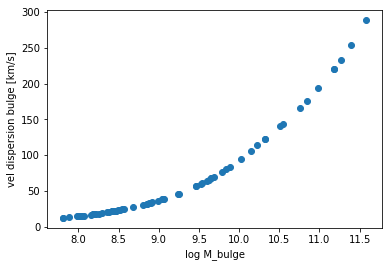

In [19]:
plt.scatter(meta['logM_bulge'], meta['vd_bulge'])
plt.xlabel('log M_bulge')
plt.ylabel('vel dispersion bulge [km/s]')

Pick a galaxy with a large velocity dispersion to make things easy to start with

In [20]:
g = np.where(meta['vd_bulge'] > 200)[0][0] #galaxy number to look at
z = meta['redshift'][g]
vdisp_bulge = meta['vd_bulge'][g]
vdisp_disk = meta['vd_disk'][g]
print('galaxy #' + str(g) + ' is at redshift ' + str(z) + ' with vel disp for bulge and disk of ' + str(vdisp_bulge) + ' and ' + str(vdisp_disk))



galaxy #35 is at redshift 0.3653412 with vel disp for bulge and disk of 253.4563457408788 and 50.0


In [21]:
#sort the data in ascending order of wavelength
wsort_bgs = np.argsort(spec_bgs['wave'])
wsort_s = np.argsort(spec_s['wave'])
wave = spec_s['wave'][wsort_s]/(1 + z) #rest-frame wavelength
wave_bgs = spec_bgs['wave'][wsort_bgs]/(1 + z) #rest-frame wavelength

flux_gal = spec_s['flux'][g][wsort_s]
flux_gal_bgs = spec_bgs['flux'][g][wsort_bgs]

Interpolate the spectrum to a common grid. We'll do this to the models, too.

In [22]:
wave_gal,flux_gal = to_common_grid(wave, flux_gal)
print(np.shape(flux_gal))

[0.53187208 0.54407479 0.5520615  ... 1.55230776 1.55010448 1.54820632]
(3501,)


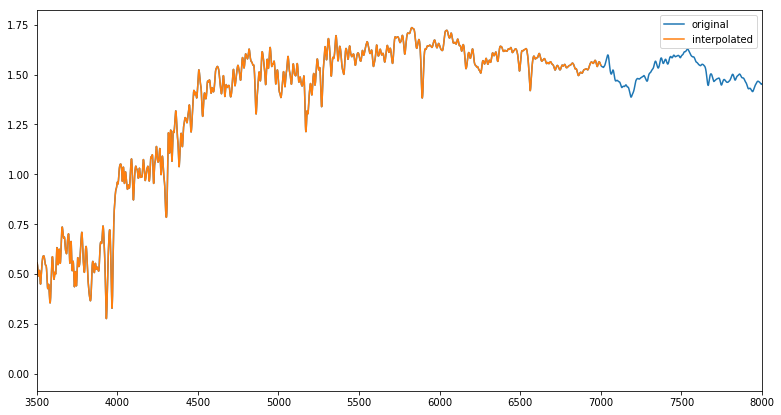

In [23]:
#a sanity check plot
plt.figure(figsize=(13,7))
plt.plot(spec_s['wave']/(1+z), spec_s['flux'][g], label='original')
plt.plot(wave_gal, flux_gal, label='interpolated')
plt.xlim(3500,8000)
plt.legend()

In [24]:
#cut to a small range in rest-frame wavelength for now
lam_bounds = [3600,6500]
mask = ((wave_gal >= lam_bounds[0]) & (wave_gal <= lam_bounds[1]))
flux_gal = flux_gal[mask]
wave_gal = wave_gal[mask]

lamrange= [wave_gal[0], wave_gal[-1]]
print(lamrange, np.shape(wave_gal))

[3600.0, 6500.0] (2901,)


Compute velocity scale and rebin in log_lambda

In [26]:
c = 299792.458                  # speed of light in km/s
frac = wave_gal[1]/wave_gal[0]    # Constant lambda fraction per pixel
velscale = np.log(frac)*c       # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)
print('velocity scale = ', velscale)

velocity scale =  83.26411885215646


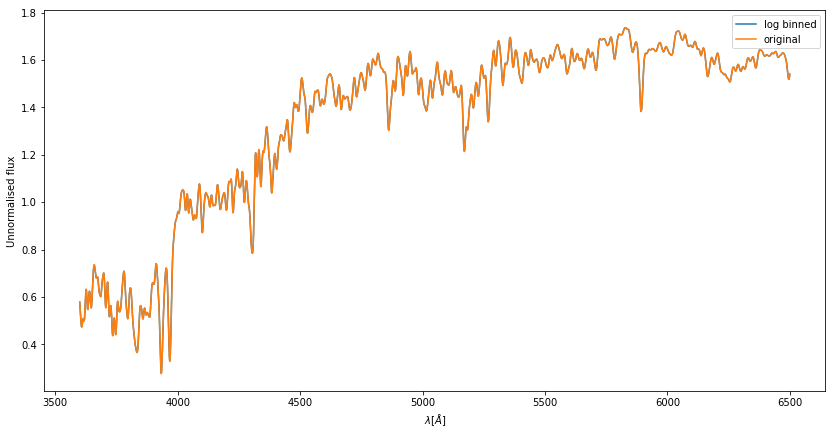

In [27]:
galaxy, logLam_gal, velscale = util.log_rebin(lamrange, flux_gal, velscale=velscale)

#plot original and rebinned spectra to make sure they match
plt.figure(figsize=(14,7))
plt.plot(np.exp(1)**logLam_gal, galaxy, label='log binned')
plt.plot(wave_gal, flux_gal, label='original')
plt.xlabel('$\lambda [\AA]$')
plt.ylabel('Unnormalised flux')
plt.legend()

#working vectors now are galaxy and lam_log both rebinned in equal bins in log_lambda
lam_gal = np.exp(1)**logLam_gal

In [14]:
len(logLam_gal)

2128

Read templates. The read_simple_templates() function already puts them in a common grid in log lambda

[2.64916588e+21 2.69400128e+21 2.76369409e+21 ... 8.34893585e+21
 8.27453874e+21 8.32049103e+21]
[4.28980014e+22 4.27820835e+22 4.31063806e+22 ... 3.56677942e+22
 3.54452968e+22 3.55515264e+22]
83.26411885215646 83.26411885215646
83.26411885215646


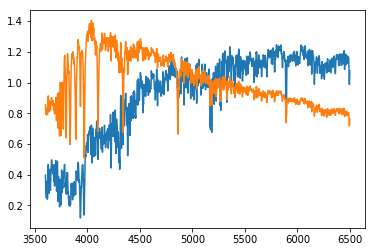

In [29]:
(loglam_temp, templates_simple) = read_simple_templates(velscale,lam_bounds)
lam_temp = np.exp(1)**loglam_temp
lamRange_temp = [np.exp(1)**loglam_temp[0],np.exp(1)**loglam_temp[-1]]
print(velscale)

In [30]:
#sanity checks - these should all match
print(lam_temp[0],lam_gal[0])
print(lam_temp[-1],lam_gal[-1])
print(np.shape(lam_temp), np.shape(lam_gal))

3599.999895842976 3599.999895842976
6499.2390763432295 6499.2390763432295
(2128,) (2128,)


In [32]:
#Lifted straight out of the ppxf examples. Note dv should be zero here as we're working on a fixed grid.

# The galaxy and the template spectra do not have the same starting wavelength.
# For this reason an extra velocity shift DV has to be applied to the template
# to fit the galaxy spectrum. We remove this artificial shift by using the
# keyword VSYST in the call to PPXF below, so that all velocities are
# measured with respect to DV. This assume the redshift is negligible.
# In the case of a high-redshift galaxy one should de-redshift its
# wavelength to the rest frame before using the line below (see above).
#
c = 299792.458   # km/s
dv = c*np.log(lam_temp[0]/lam_gal[0])    # eq.(8) of Cappellari (2017)
print(dv)
goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, z)



0.0


[0, 200.0]
Best Fit:       Vel     sigma
 comp. 0:        35       223
chi2/DOF: 0.0003873
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
Nonzero (>0.1%) Templates: 2 / 2
Templates weights:
      1.28    0.0731
Formal errors:
     dV    dsigma   dh3      dh4
     2.3     2.4
Elapsed time in PPXF: 0.06 s


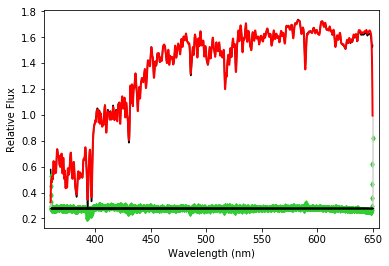

In [33]:
#Ditto.

# Here the actual fit starts. The best fit is plotted on the screen.
# Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
#
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [0, 200.]  # (km/s), starting guess for [V, sigma]
print(start)
noise=np.ones_like(galaxy)
t = clock()

pp = ppxf(templates_simple, galaxy,noise, velscale, start,plot=True, \
          moments=2, degree=4, vsyst=dv, clean=False, lam=lam_gal)

print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

print('Elapsed time in PPXF: %.2f s' % (clock() - t))